In [1]:
import json
import dimod
import math
from collections import defaultdict
from dwave.system import LeapHybridSampler, DWaveSampler, EmbeddingComposite
# import dwavebinarycsp
import dwave.inspector
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import rand_score, adjusted_rand_score
import pandas as pd
import random
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import os
import mplcyberpunk
from matplotlib import colors
import colorsys
from dotenv import load_dotenv

load_dotenv();

In [2]:
# initialize global variables (to be re-valued in demo() )
nv = 1 
nt = 5

def get_max_coeff(mydict):
    return max([abs(v) for v in mydict.values()])

def angle_diff(a, b):
    return 2*abs((a - b + 0.5) % 1.0 - 0.5)

In [3]:
"""

This is the part of the code that deals with quantum annealing. Paper reference: https://arxiv.org/abs/1903.08879

The first function, g_from_AJpaper_QUBO(), shows the many different
ways we can determine this g() factor from the paper. In the paper, it was defined as 1 - e^-mx, which we found to be inefficient 
last year. We chose 1 + ln(mx) instead, which gave better results

create_qubo() creates the problem and translates it into a qubo, which is the mathematical form of the problem that a quantum annealer
can compute. This function is based around the paper above, equation 4, which encodes the clustering problem into a qubo.
    Remember: the "qubo" that we create is a problem based around the ising spin equation, shown in equation 1. 
    p_ik represents the probability (0, no, or 1, yes) of particle i belonging to vertex k, while p_jk is the same for particle j
    The triple summation of equation 4 represents the qubit couplings, where we scale whether we think particles i and j belong
        to the same vertex k by using function g(Dij).
    The next double summation is a penalty sum, focused on the qubit biases. This means that it enforces the rule that each logical 
        qubit (each particle) only belongs to one vertex

run_qa() receives that completed qubo from create_qubo() and sends it to the annealer itself, along with the parameters num_reads,
    chain_strength and annealing_time. These are important later, but here are some summaries:
        num_reads: more reads corresponds to your best solution being more accurate (more samples),
        chain_strength: this is a very particular value. If it is too high, it will add an uneven bias to pollute our answer,
            but if it is too low, then it will not enforce qubit connections that well, which is required to correctly 
            represent the qubo on the annealing machine
        annealing_time: any shorter than 50 microseconds will give bad results because it is too short of a computation to allow bits
            to quantum tunnel, and too long is wasteful over high numbers of reads

Finally, set_solution_from_annealer_response() receives the finished computations from the annealer (response is a bunch of 
    dictionaries corresponding to each 'read' from num_reads). These responses are sorted, with the first being the lowest energy,
    and therefore the most correct (assuming your QUBO represents the problem). Remember, the physics behind the problem hamiltonians
    and qubos that are derived from them is that lower system energies are preferred. This is why we anneal!

    After this, the function checks the solutions to 
"""


def g_from_AJpaper_QUBO(m, Dij):
    """
    The purpose of this function is to scale the energy levels
    so that the lowest levels are more separated from each other.

    This represents the function g(Dij) in the paper, known as the distortion function. It distorts the distance between any points applied to it

    This is helpful because we may get better results if we use log(Dij) instead of the function used by the paper
    """
    # Dij -= 2
    # Dij *= 5
    # print("Dij =", Dij)
    # return math.log(Dij)
    # return Dij
    return 1 + math.log(Dij*m)
    # return Dij ** 0.25 + Dij ** 0.5
    # return m + math.log(Dij)
    # m = 5
    # return 1 - math.exp(-m*Dij)

def create_qubo(df, m, nv):
    Z = df['z']
    T = df['theta']
    P = df['momentum']
    # # # # # #
    # # # # # #
    nT = len(Z)

    qubo = defaultdict(float)
    Dij_max = 0

    # Define QUBO terms for the first summation
    for k in range(nv):
        for i in range(nT):
            for j in range(i+1, nT):
                Dij = ((Z[i] - Z[j])**2 + angle_diff(T[i], T[j])**2) ** 0.5
                Dij_max = max(Dij_max, Dij)
                # print(g_from_AJpaper_QUBO(m, Dij) + min(P[i], P[j]))
                # print(g(m, Dij), min(P[i], P[j]))
                # we add the min(P[i], P[j]) term to prevent high momentum tracks from being assigned to the same vertex
                qubo[(i+nT*k, j+nT*k)] = g_from_AJpaper_QUBO(m, Dij) + min(P[i], P[j]) # * (P[i] + P[j]) # prevent high momentum tracks from being assigned to same vertex

    # print("Dij_max", Dij_max, "Max before constraint", get_max_coeff(qubo))
    lam = 1.0 * get_max_coeff(qubo)

    # Define QUBO terms for penalty summation
    # Note, we ignore a constant 1 as it does not affect the optimization
    # https://docs.dwavesys.com/docs/latest/c_gs_6.html
    for i in range(nT):
        for k in range(nv):
            qubo[(i+nT*k, i+nT*k)] -= lam
            for l in range(k+1, nv):
                qubo[(i+nT*k, i+nT*l)] += 2 * lam

    return qubo

def run_qa(df, qubo):
    # # # # 
    # # # # 
    strength = math.ceil(get_max_coeff(qubo))
    sampler = EmbeddingComposite(DWaveSampler(token=os.getenv("TOKEN")))
    response = sampler.sample_qubo(qubo, num_reads=100, chain_strength=strength, annealing_time = 50) # Don't mess with this until you understand it
    best = response.first.sample
    # TO INSPECT PROBLEM
    dwave.inspector.show(response)
    # print(best)
    set_solution_from_annealer_response(df, best)
    
def set_solution_from_annealer_response(df, response):
    nT = len(df)
    track_to_vertex = [None] * nT
    # nV = get_nv_from_p(df['momentum'])

    for num, bool in response.items(): # this part is important to understand, maybe try printing out the response to understand the definition of i,k
        print(response)
        if bool == 1:
            i = num % nT # track number
            k = num // nT # vertex number

            if track_to_vertex[i] != None:
                print("Invalid solution! Track assigned to multiple vertices.")
                # track_to_vertex = None
                df['qagroup'] = None
                return
            else:
                track_to_vertex[i] = k
    
    if None in track_to_vertex:
        print("Invalid solution! Track assigned to no vertex :(")
        track_to_vertex = None
    
    else:
        print("Anneal returned valid results! }:D")
    df['qagroup'] = track_to_vertex
    print("Printing track_to_vertex, the assigned vertexes to each particle")
    print(track_to_vertex)


In [4]:

def get_reasonable_sizes_for_plotting_momentum(P):
    return [500 * p**0.6 for p in P]
    # return [50 * p ** 0.25 for p in P]

def rand_cmap_for_plotting(nlabels, type='bright'):

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [((np.random.uniform(low=0.0, high=1)),
                          np.random.uniform(low=0.7, high=1),
                          np.random.uniform(low=0.9, high=1)) for _ in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        # random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)
        return randRGBcolors
    # Generate soft pastel colors
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for _ in range(nlabels)]
        # random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)
        return randRGBcolors


palette = rand_cmap_for_plotting(30, type='bright')


def plot_clusters(df, grouping, title, saveto=None):
    all_zs = df['z']
    all_thetas = df['theta']
    all_ps = df['momentum']

    # palette = ['b', 'g', 'r', 'c', 'm', 'y'] # 6 is enough
    colors = [palette[i] for i in grouping]
    scaled = get_reasonable_sizes_for_plotting_momentum(all_ps)
    # plt.scatter(all_zs, all_thetas, c=all_ps)
    plt.figure()
    plt.title(title)
    plt.xlabel("Z (normalized)")
    plt.ylabel("θ (normalized)")
    plt.grid()
    for (i, z) in enumerate(all_zs):
        plt.scatter(z, all_thetas[i], color=colors[i], s=scaled[i], alpha=0.5)
        # mplcyberpunk.make_scatter_glow()
    if saveto is not None:
        plt.savefig(saveto)
        plt.close() # avoid displaying the plot

In [5]:
def score_clusters(truth, solution):
    if len(solution) == 0:
        return 0.0
    if solution.isnull().any():
        return 0.0
    return 100.0 * adjusted_rand_score(truth, solution)

def get_rand_from_number_of_vertices(v):
    elem = v[np.random.randint(len(v))]
    v.remove(elem)
    return elem

def generate_clusters(nt=16, nv=2, std=0.02):

    z_range = 1 # 0 to 1
    theta_range = 1 # 0 to 1 (we're acting like we squished the ranges)
    num_tracks = nt

    p = np.random.rand(num_tracks)
    p = 1/(p**2 + 0.001) # 3 orders of magnitude diff between min and max. corresponds to: 30 MeV, 30 GeV scaled
    p /= p.max()

    p = np.sort(p)[::-1].tolist()

    hard_ps = p[:nv]
    soft_ps = p[nv:]

    vertex_zs = np.random.rand(nv) * z_range
    vertex_thetas = np.random.rand(nv) * theta_range

    points_per_cluster = num_tracks // nv
    remainder = num_tracks % nv

    all_zs = []
    all_thetas = []
    all_ps = []
    truth = [] # which cluster each point belongs to
    for i in range(nv):
        z = vertex_zs[i]
        theta = vertex_thetas[i]

        # -1 because we're going to add the vertex itself too
        toadd = points_per_cluster - 1 + (1 if i < remainder else 0)
        for j in range(toadd):
            all_zs.append(z + np.random.normal(scale=std))
            all_thetas.append((theta + np.random.normal(scale=std)) % 1.0) # modulo 1.0 to keep it in the range
            all_ps.append(get_rand_from_number_of_vertices(soft_ps))
            truth.append(i)
        all_zs.append(z)
        all_thetas.append(theta)
        all_ps.append(get_rand_from_number_of_vertices(hard_ps))
        truth.append(i)
    # all_zs = np.array(all_zs)
    # all_thetas = np.array(all_thetas)
    DF = pd.DataFrame({'z': all_zs, 'theta': all_thetas, 'momentum': all_ps, 'truegroup': truth})
    DF.to_csv('TEST_DATA.csv')
    return DF

    # return (n, all_zs, all_thetas, all_ps, truth)


In [6]:
"""
THIS IS THE CENTRALIZED PLACE TO CHANGE PARAMETERS
"""

nv = 3
nt = 10

def demo(): # Simplified to not deal with anti-kt yet. Can change nv, nT, cluster size std
    std = 0.06
    df = generate_clusters(nt, nv, std=std)
    qubo = create_qubo(df, nv-1, nv)
    # df = generate_clusters(nt=16, nv=4, std=std)
    # df = generate_clusters(nt=12, nv=5, std=std)
    plot_clusters(df, df['truegroup'], "Generated Clusters")

    print("DATA GENNED")
    print(df)

    print("SENDING TO QA")

    run_qa(df, qubo)

    print("SOLUTION RECEIVED")
    print(df)
    qascore = score_clusters(df['truegroup'], df['qagroup'])
    
    plot_clusters(df, df['qagroup'], f"Annealer solution, Adj. Rand index {qascore:.1f}%")
    
    # print("Score:", score)
    print(df)

    df['qascore'] = qascore

    df.to_csv("df.csv", index=False)

DATA GENNED
          z     theta  momentum  truegroup
0  0.452361  0.968223  0.061257          0
1  0.433950  0.048106  0.057330          0
2  0.333922  0.032977  0.107490          0
3  0.380774  0.035195  0.296854          0
4  0.875244  0.212606  0.203170          1
5  0.897089  0.324514  0.052513          1
6  0.985937  0.205142  0.517197          1
7  0.711022  0.955505  0.149353          2
8  0.769940  0.007510  0.193214          2
9  0.780506  0.950806  1.000000          2
SENDING TO QA


Serving Inspector on http://0.0.0.0:18000/?problemId=d02156ca-21be-45da-aba0-4fb4007b5424

{0: np.int8(0), 1: np.int8(0), 2: np.int8(0), 3: np.int8(0), 4: np.int8(0), 5: np.int8(0), 6: np.int8(0), 7: np.int8(1), 8: np.int8(1), 9: np.int8(1), 10: np.int8(1), 11: np.int8(1), 12: np.int8(1), 13: np.int8(1), 14: np.int8(0), 15: np.int8(0), 16: np.int8(0), 17: np.int8(0), 18: np.int8(0), 19: np.int8(0), 20: np.int8(0), 21: np.int8(0), 22: np.int8(0), 23: np.int8(0), 24: np.int8(1), 25: np.int8(1), 26: np.int8(1), 27: np.int8(0), 28: np.int8(0), 29: np.int8(0)}
{0: np.int8(0), 1: np.int8(0), 2: np.int8(0), 3: np.int8(0), 4: np.int8(0), 5: np.int8(0), 6: np.int8(0), 7: np.int8(1), 8: np.int8(1), 9: np.int8(1), 10: np.int8(1), 11: np.int8(1), 12: np.int8(1), 13: np.int8(1), 14: np.int8(0), 15: np.int8(0), 16: np.int8(0), 17: np.int8(0), 18: np.int8(0), 19: np.int8(0), 20: np.int8(0), 21: np.int8(0), 22: np.int8(0), 23: np.int8(0), 24: np.int8(1), 25: np.int8(1), 26: np.int8(1), 27: np.int8(0), 28: np.int8(0), 29: np.int8(0)}
{0: np.int8(0), 1: np.int8(0), 2: np.int8(0), 3: np.int8(0

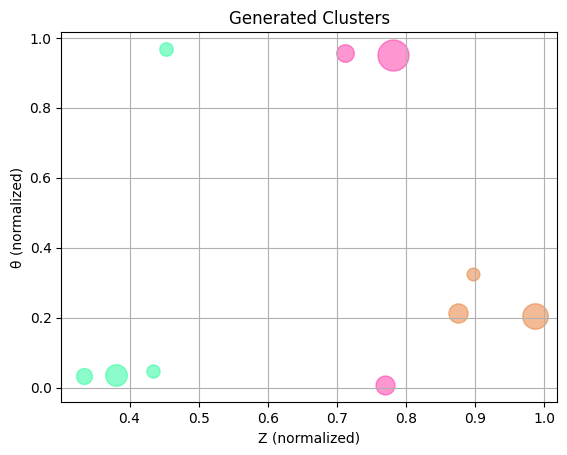

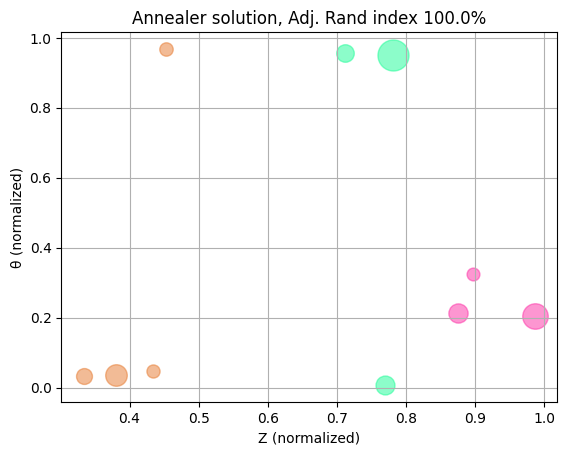

In [7]:
# Here we run the code

demo()
